# Wildfire Analysis
## Overview
TODO

## Scientific Methodology
https://ec.europa.eu/jrc/en/publication/forest-fire-danger-extremes-europe-under-climate-change-variability-and-uncertainty

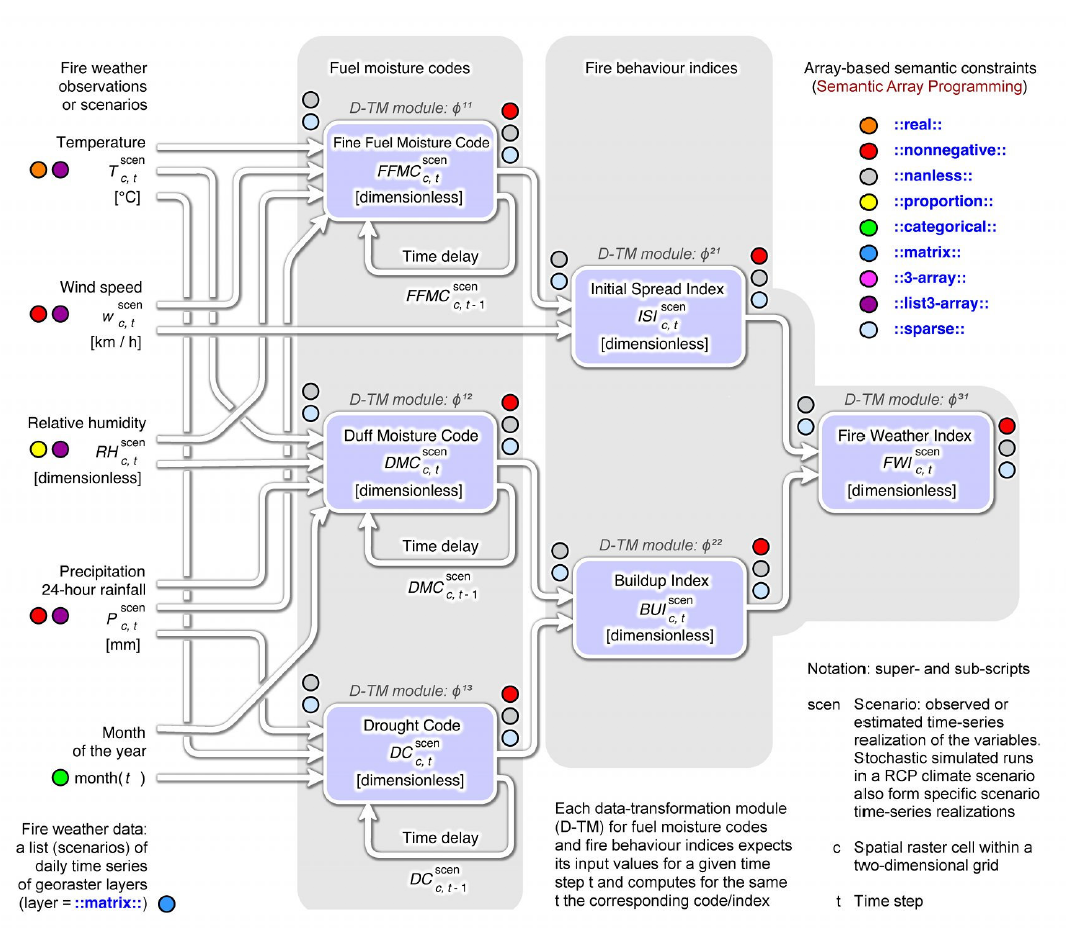

## Data Documentation
http://datastore.copernicus-climate.eu/documents/sis-european-tourism/C3S_D422_Lot2_TEC_FWI_dataset_description_v1.1.pdf


## Workflow
- Read in data and combine by model dimension
- Review ensemble spread and mean for any outliers
- Conduct change analysis for # of days with moderate, high and very high FWI


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.ndimage as ndimage
import matplotlib.ticker as mticker

import plotly as py
import plotly.offline as py_off
from plotly.graph_objs import *
from scipy.io import netcdf
import geopandas

In [157]:
# Combine RCP45 frequency files into ensemble

model_list = ['CNRM-CERFACS-CNRM-CM5', 'ICHEC-EC-EARTH', 'IPSL-IPSL-CM5A-MR', 'MOHC-HadGEM2-ES','MPI-M-MPI-ESM-LR']
index_list = ['15','30','45']
input_dir = '/path/to/input_dir/CORDEX_Historical_Individual_Models/'

for index in index_list:
    ensemble_list = []
    for model in model_list:
        file_name = f'eur11_rca4_{model}_historical_fwi-nods-gt-{index}_19810101_20051231_v1.nc'
        model_file = xr.open_dataset(input_dir+file_name)
        model_file = model_file.drop("time_bnds")
        model_file = model_file.assign(time=model_file.time.dt.year + 1)
        model_file = model_file.assign_coords({'model': f'{model}'}).expand_dims({'model': 1})
        ensemble_list.append(model_file)

    ensemble_ds = xr.concat(ensemble_list, 'model')

    if index == '15':
        severity = "mod"
    elif index == '30':
        severity = "high"
    elif index == '45':
        severity = "very_high"

    ensemble_ds.load().to_netcdf(f'/path/to/output_dir/hist_ensemble_{severity}_fwi_eu.nc')



In [158]:
# Manual check mod, high, very high output files
hist_qc = xr.open_dataset('/path/to/output_dir/hist_ensemble_mod_fwi_eu.nc')
hist_qc


<xarray.Dataset>
Dimensions:         (model: 5, rlat: 412, rlon: 424, time: 25)
Coordinates:
    lat             (rlat, rlon) float64 ...
    lon             (rlat, rlon) float64 ...
  * time            (time) int64 1981 1982 1983 1984 ... 2002 2003 2004 2005
  * rlat            (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon            (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * model           (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'MPI-M-MPI-ESM-LR'
Data variables:
    rotated_pole    (model) |S1 ...
    fwi-nods-gt-15  (model, time, rlat, rlon) float64 ...
Attributes:
    creation_date:  2019-06-30-T11:12:49Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-nods-gt-15
    references:     van Wagner, C. E., (1987). Development and structure of a...
    Project:        C3S European Tourism
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

In [108]:
# Combine RCP45 frequency files into ensemble

model_list = ['CNRM-CERFACS-CNRM-CM5', 'ICHEC-EC-EARTH', 'IPSL-IPSL-CM5A-MR', 'MOHC-HadGEM2-ES','MPI-M-MPI-ESM-LR']
index_list = ['15','30','45']
time_list = ['20210101_20401231','20410101_20601231']
input_dir = '/path/to/input_dir/CORDEX_RCP45_Individual_Models/'

for time in time_list:
    for index in index_list:
        ensemble_list = []
        for model in model_list:
            file_name = f'eur11_rca4_{model}_rcp45_fwi-nods-gt-{index}_{time}_v1.nc'
            model_file = xr.open_dataset(input_dir+file_name)
            model_file = model_file.assign(time=model_file.time.dt.year + 1)
            model_file = model_file.drop("time_bnds")   
            model_file = model_file.assign_coords({'model': f'{model}'}).expand_dims({'model': 1})
            ensemble_list.append(model_file)
            
        ensemble_ds = xr.concat(ensemble_list, 'model')
        
        if index == '15':
            severity = "mod"
        elif index == '30':
            severity = "high"
        elif index == '45':
            severity = "very_high"
            
        if time == '20210101_20401231':
            fut = '2030'
        elif time == '20410101_20601231':
            fut = '2050'
            
        ensemble_ds.load().to_netcdf(f'/path/to/output_dir/rcp45_ensemble_{severity}_fwi_eu_{fut}.nc')


In [114]:
# Man Check mod, high, very high output files for 2030, 2050
rcp45_qc = xr.open_dataset('/path/to/output_dir/rcp45_ensemble_very_high_fwi_eu_2050.nc')
rcp45_qc


<xarray.Dataset>
Dimensions:         (model: 5, rlat: 412, rlon: 424, time: 20)
Coordinates:
    lat             (rlat, rlon) float64 ...
    lon             (rlat, rlon) float64 ...
  * time            (time) int64 2041 2042 2043 2044 ... 2057 2058 2059 2060
  * rlat            (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon            (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * model           (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'MPI-M-MPI-ESM-LR'
Data variables:
    rotated_pole    (model) |S1 ...
    fwi-nods-gt-45  (model, time, rlat, rlon) float64 ...
Attributes:
    creation_date:  2019-06-30-T14:52:28Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-nods-gt-45
    references:     van Wagner, C. E., (1987). Development and structure of a...
    Project:        C3S European Tourism
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

In [121]:
# Combine RCP85 frequency files into ensemble

model_list = ['CNRM-CERFACS-CNRM-CM5', 'ICHEC-EC-EARTH', 'IPSL-IPSL-CM5A-MR', 'MOHC-HadGEM2-ES','MPI-M-MPI-ESM-LR']
index_list = ['15','30','45']
time_list = ['20210101_20401231','20410101_20601231']
input_dir = '/path/to/input_dir/CORDEX_RCP85_Individual_Models/'

for time in time_list:
    for index in index_list:
        ensemble_list = []
        for model in model_list:
            file_name = f'eur11_rca4_{model}_rcp85_fwi-nods-gt-{index}_{time}_v1.nc'
            model_file = xr.open_dataset(input_dir+file_name)
            model_file = model_file.assign(time=model_file.time.dt.year + 1)
            model_file = model_file.drop("time_bnds")      
            model_file = model_file.assign_coords({'model': f'{model}'}).expand_dims({'model': 1})
            ensemble_list.append(model_file)
            
        ensemble_ds = xr.concat(ensemble_list, 'model')
        
        if index == '15':
            severity = "mod"
        elif index == '30':
            severity = "high"
        elif index == '45':
            severity = "very_high"
            
        if time == '20210101_20401231':
            fut = '2030'
        elif time == '20410101_20601231':
            fut = '2050'
            
        ensemble_ds.load().to_netcdf(f'/path/to/output_dir/rcp85_ensemble_{severity}_fwi_eu_{fut}.nc')


In [127]:
# Manual check mod, high, very high output files for 2030, 2050
rcp85_qc = xr.open_dataset('/path/to/output_dir/rcp85_ensemble_mod_fwi_eu_2030.nc')
rcp85_qc


<xarray.Dataset>
Dimensions:         (model: 5, rlat: 412, rlon: 424, time: 20)
Coordinates:
    lat             (rlat, rlon) float64 ...
    lon             (rlat, rlon) float64 ...
  * time            (time) int64 2021 2022 2023 2024 ... 2037 2038 2039 2040
  * rlat            (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon            (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * model           (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'MPI-M-MPI-ESM-LR'
Data variables:
    rotated_pole    (model) |S1 ...
    fwi-nods-gt-15  (model, time, rlat, rlon) float64 ...
Attributes:
    creation_date:  2019-06-30-T11:14:35Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-nods-gt-15
    references:     van Wagner, C. E., (1987). Development and structure of a...
    Project:        C3S European Tourism
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

In [413]:
# Read in pre-processed ensemble files to analyze future changes in FWI days per year 
# in each given future time period i.e. 2041-2060 gives 2050 view

his_period = ['1986', '2005']
fut_period = ['2041', '2060']

# TODO: make file names as input for level i.e. mod and time i.e. 2050 vs. hard-coded

hist_fire = xr.open_dataset('/path/to/input_dir/hist_ensemble_mod_fwi_eu.nc')
rcp45_fire = xr.open_dataset('/path/to/input_dir/rcp45_ensemble_mod_fwi_eu_2050.nc')
rcp85_fire = xr.open_dataset('/path/to/input_dir/rcp85_ensemble_mod_fwi_eu_2050.nc')

# In case you need to exclude a given model after ensemble spread analysis, 
# you can use these lines to select which models to keep for the ensemble mean

#rcp85_fire = rcp85_fire.sel(model=['CNRM-CERFACS-CNRM-CM5', 'ICHEC-EC-EARTH', 'IPSL-IPSL-CM5A-MR','MOHC-HadGEM2-ES', 'MPI-M-MPI-ESM-LR'])
#rcp45_fire = rcp45_fire.sel(model=['CNRM-CERFACS-CNRM-CM5', 'ICHEC-EC-EARTH', 'IPSL-IPSL-CM5A-MR','MOHC-HadGEM2-ES', 'MPI-M-MPI-ESM-LR'])



In [414]:
hist_fire = hist_fire.sel(time=slice(his_period[0],his_period[1])).drop("rotated_pole")
hist_fire

<xarray.Dataset>
Dimensions:         (model: 5, rlat: 412, rlon: 424, time: 20)
Coordinates:
    lat             (rlat, rlon) float64 ...
    lon             (rlat, rlon) float64 ...
  * time            (time) int64 1986 1987 1988 1989 ... 2002 2003 2004 2005
  * rlat            (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon            (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * model           (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'MPI-M-MPI-ESM-LR'
Data variables:
    fwi-nods-gt-15  (model, time, rlat, rlon) float64 ...
Attributes:
    creation_date:  2019-06-30-T11:12:49Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-nods-gt-15
    references:     van Wagner, C. E., (1987). Development and structure of a...
    Project:        C3S European Tourism
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

In [415]:
rcp45_fire = rcp45_fire.sel(time=slice(fut_period[0],fut_period[1])).drop("rotated_pole") 
rcp45_fire

<xarray.Dataset>
Dimensions:         (model: 5, rlat: 412, rlon: 424, time: 20)
Coordinates:
    lat             (rlat, rlon) float64 ...
    lon             (rlat, rlon) float64 ...
  * time            (time) int64 2041 2042 2043 2044 ... 2057 2058 2059 2060
  * rlat            (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon            (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * model           (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'MPI-M-MPI-ESM-LR'
Data variables:
    fwi-nods-gt-15  (model, time, rlat, rlon) float64 ...
Attributes:
    creation_date:  2019-06-30-T11:08:48Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-nods-gt-15
    references:     van Wagner, C. E., (1987). Development and structure of a...
    Project:        C3S European Tourism
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

In [416]:
rcp85_fire = rcp85_fire.sel(time=slice(fut_period[0],fut_period[1])).drop("rotated_pole")
rcp85_fire

<xarray.Dataset>
Dimensions:         (model: 5, rlat: 412, rlon: 424, time: 20)
Coordinates:
    lat             (rlat, rlon) float64 ...
    lon             (rlat, rlon) float64 ...
  * time            (time) int64 2041 2042 2043 2044 ... 2057 2058 2059 2060
  * rlat            (rlat) float64 -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
  * rlon            (rlon) float64 -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * model           (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'MPI-M-MPI-ESM-LR'
Data variables:
    fwi-nods-gt-15  (model, time, rlat, rlon) float64 ...
Attributes:
    creation_date:  2019-06-30-T11:16:23Z
    Frequency:      Annual
    institution:    National Observatory of Athens, URL: http://www.noa.gr
    contact:        cgiannak@noa.gr
    title:          fwi-nods-gt-15
    references:     van Wagner, C. E., (1987). Development and structure of a...
    Project:        C3S European Tourism
    history:        Version: 0.01
    Lineage:        
    Summary:        
    Keywords:       
    comment:        None
    License:        License to Use Copernicus Products

CNRM-CERFACS-CNRM-CM5, 0


/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



ICHEC-EC-EARTH, 1
IPSL-IPSL-CM5A-MR, 2


/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice

/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



MOHC-HadGEM2-ES, 3
MPI-M-MPI-ESM-LR, 4


/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice

/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice

/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



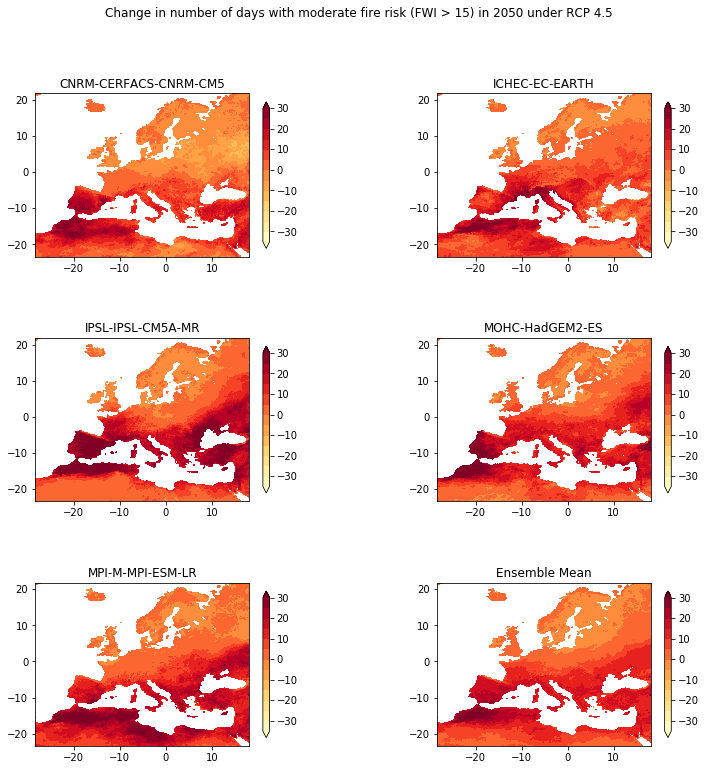

In [417]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.flatten()

i = 0

# Loop through individual model members and plot
for model in hist_fire.model.values:
    print(f'{model}, {i}')
    mod_hist_fire = hist_fire.sel(model=slice(f'{model}',f'{model}'))
    #test_hist = mod_hist_fire.mean(['time', 'model'])
    mod_rcp45_fire = rcp45_fire.sel(model=slice(f'{model}',f'{model}'))
    #test_rcp45 = mod_rcp45_fire.mean(['time', 'model'])
    change45_mod = mod_rcp45_fire.mean(['time', 'model']) - mod_hist_fire.mean(['time', 'model'])
    axs[i].contourf(change45_mod.rlon,change45_mod.rlat,change45_mod['fwi-nods-gt-15'],cmap='Reds')
    axs[i].set_title(f'{model}')
    cs = axs[i].contourf(change45_mod.rlon,change45_mod.rlat,change45_mod['fwi-nods-gt-15'], # TODO: remove hard-coded varnames
                     levels=np.arange(-35.0,35.0,5), cmap='YlOrRd', extend='both')
    fig.colorbar(cs, ax=axs[i], shrink=0.9)
    i = i + 1
    
change45_mod = rcp45_fire.mean(['time', 'model']) - hist_fire.mean(['time', 'model'])
axs[5].contourf(change45_mod.rlon,change45_mod.rlat,change45_mod['fwi-nods-gt-15'],cmap='Reds')
axs[5].set_title('Ensemble Mean')
cs = axs[5].contourf(change45_mod.rlon,change45_mod.rlat,change45_mod['fwi-nods-gt-15'],
                     levels=np.arange(-35.0,35.0,5), cmap='YlOrRd', extend='both')
fig.colorbar(cs, ax=axs[5], shrink=0.9)
fig.suptitle('Change in number of days with moderate fire risk (FWI > 15) in 2050 under RCP 4.5') # TODO: remove hardcoded title and figure names

plt.savefig(f'/path/to/output_dir/hist_rcp45_ensemble_spread_change_mod_fwi_2050.png',bbox_inches = 'tight', dpi=300)


/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



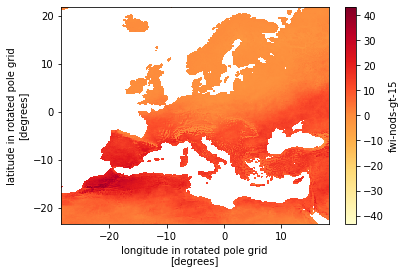

In [418]:
# Check absolute change (in # of days) map for ensemble mean (RCP 4.5 - Historical)
change45 = rcp45_fire.mean(['time', 'model']) - hist_fire.mean(['time', 'model'])
change45['fwi-nods-gt-15'].plot(cmap='YlOrRd')

In [419]:
# Save change file to netcdf for scenario/time period

change45.load().to_netcdf(f'/path/to/output_dir/Ensemble_Change_Outputs/Mod_FWI_Mean_Ensemble_Change_RCP45_2050.nc')


CNRM-CERFACS-CNRM-CM5, 0
ICHEC-EC-EARTH, 1


/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice

/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



IPSL-IPSL-CM5A-MR, 2
MOHC-HadGEM2-ES, 3


/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice

/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



MPI-M-MPI-ESM-LR, 4


/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice

/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



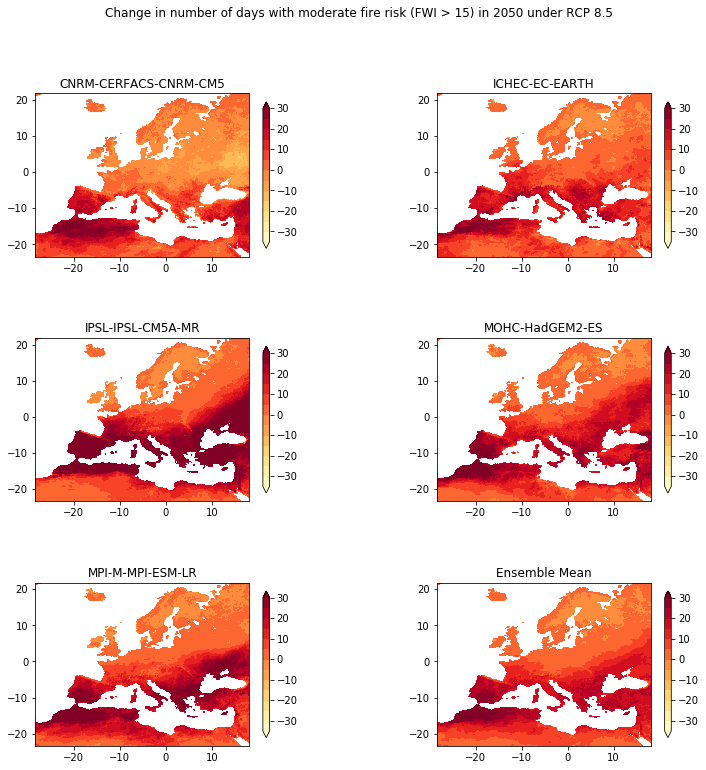

In [420]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.flatten()

i = 0

# Loop through individual model members and plot
for model in hist_fire.model.values:
    print(f'{model}, {i}')
    mod_hist_fire = hist_fire.sel(model=slice(f'{model}',f'{model}'))
    #test_hist = mod_hist_fire.mean(['time', 'model'])
    mod_rcp85_fire = rcp85_fire.sel(model=slice(f'{model}',f'{model}'))
    #test_rcp85 = mod_rcp85_fire.mean(['time', 'model'])
    change85_mod = mod_rcp85_fire.mean(['time', 'model']) - mod_hist_fire.mean(['time', 'model'])
    axs[i].contourf(change85_mod.rlon,change85_mod.rlat,change85_mod['fwi-nods-gt-15'],cmap='Reds')
    axs[i].set_title(f'{model}')
    cs = axs[i].contourf(change85_mod.rlon,change85_mod.rlat,change85_mod['fwi-nods-gt-15'],
                     levels=np.arange(-35.0,35.0,5), cmap='YlOrRd', extend='both')
    fig.colorbar(cs, ax=axs[i], shrink=0.9)
    i = i + 1
    
change85_mod = rcp85_fire.mean(['time', 'model']) - hist_fire.mean(['time', 'model'])
axs[5].contourf(change85_mod.rlon,change85_mod.rlat,change85_mod['fwi-nods-gt-15'],cmap='Reds')
axs[5].set_title('Ensemble Mean')
cs = axs[5].contourf(change85_mod.rlon,change85_mod.rlat,change85_mod['fwi-nods-gt-15'],
                     levels=np.arange(-35.0,35.0,5), cmap='YlOrRd', extend='both')
fig.colorbar(cs, ax=axs[5], shrink=0.9)
fig.suptitle('Change in number of days with moderate fire risk (FWI > 15) in 2050 under RCP 8.5')

plt.savefig(f'/path/to/output_dir/hist_rcp85_ensemble_spread_change_mod_fwi_2050.png',bbox_inches = 'tight', dpi=300)

/Users/Lori_Fomenko/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning:

Mean of empty slice



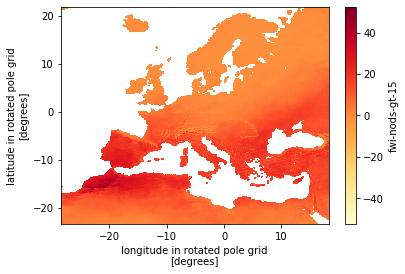

In [421]:
# Check absolute change (in # of days) map for ensemble mean (RCP 8.5 - Historical)

change85 = rcp85_fire.mean(['time', 'model']) - hist_fire.mean(['time', 'model'])
change85['fwi-nods-gt-15'].plot(cmap='YlOrRd')

In [422]:
# Save change file to netcdf for scenario/time period

change85.load().to_netcdf(f'/path/to/output_dir/Ensemble_Change_Outputs/Mod_FWI_Mean_Ensemble_Change_RCP85_2050.nc')
